# Week 13 - SVM (Ch5)

The following is adapted from **Chapter 5 of Hands-on Machine Learning** book. Please refer to Chapter 5 of the Hands-on Machine Learning book, accessible via the link provided in the course outline.

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml3/blob/main/05_support_vector_machines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml3/blob/main/05_support_vector_machines.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

This project requires Python 3.7 or above:

In [1]:
import sys

# This project requires Python 3.7 or above:
assert sys.version_info >= (3, 7)

# requires Scikit-Learn ≥ 1.0.1
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

# define the default font sizes to make the figures prettier
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)


And let's create the `images/svm` folder (if it doesn't already exist), and define the `save_fig()` function which is used through this notebook to save the figures in high-res for the book:

In [2]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "svm"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Support Vector Machine 

A support vector machine (SVM) is a powerful and versatile machine learning model, capable of performing linear or nonlinear classification, regression, and even novelty detection. SVMs shine with small to medium-sized nonlinear datasets (i.e., hundreds to thousands of instances), especially for classification tasks. However, they don’t scale very well to very large datasets, as you will see.

This chapter will explain the core concepts of SVMs, how to use them, and how they work. Let’s jump right in!

# Linear SVM Classification

The fundamental idea behind SVMs is best explained with some visuals. Figure below shows part of the iris dataset that was introduced at the end of Chapter 4. The two classes can clearly be separated easily with a straight line (they are _linearly separable_). The left plot shows the decision boundaries of three possible linear classifiers. The model whose decision boundary is represented by the dashed line is so bad that it does not even separate the classes properly. The other two models work perfectly on this training set, but their decision boundaries come so close to the instances that these models will probably not perform as well on new instances. In contrast, the solid line in the plot on the right represents the decision boundary of an SVM classifier; this line not only separates the two classes but also stays as far away from the closest training instances as possible. You can think of an SVM classifier as fitting the widest possible street (represented by the parallel dashed lines) between the classes. This is called _large margin_ classification.



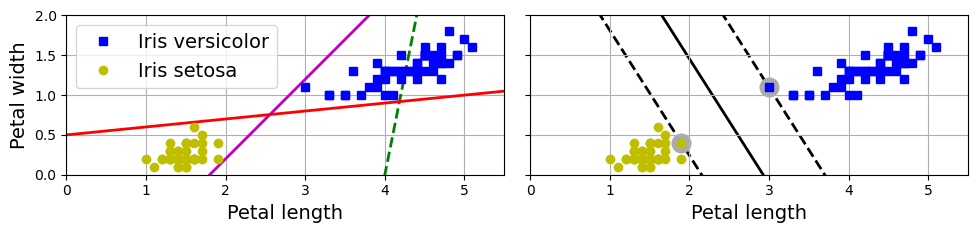

In [3]:
# extra code – this cell generates and saves Figure 5–1

import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC
from sklearn import datasets

iris = datasets.load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris.target

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

# SVM Classifier model
svm_clf = SVC(kernel="linear", C=1e100)
svm_clf.fit(X, y)

# Bad models
x0 = np.linspace(0, 5.5, 200)
pred_1 = 5 * x0 - 20
pred_2 = x0 - 1.8
pred_3 = 0.1 * x0 + 0.5

def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0] / w[1] * x0 - b / w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin
    svs = svm_clf.support_vectors_

    plt.plot(x0, decision_boundary, "k-", linewidth=2, zorder=-2)
    plt.plot(x0, gutter_up, "k--", linewidth=2, zorder=-2)
    plt.plot(x0, gutter_down, "k--", linewidth=2, zorder=-2)
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#AAA',
                zorder=-1)

fig, axes = plt.subplots(ncols=2, figsize=(10, 2.7), sharey=True)

plt.sca(axes[0])
plt.plot(x0, pred_1, "g--", linewidth=2)
plt.plot(x0, pred_2, "m-", linewidth=2)
plt.plot(x0, pred_3, "r-", linewidth=2)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="upper left")
plt.axis([0, 5.5, 0, 2])
plt.gca().set_aspect("equal")
plt.grid()

plt.sca(axes[1])
plot_svc_decision_boundary(svm_clf, 0, 5.5)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.xlabel("Petal length")
plt.axis([0, 5.5, 0, 2])
plt.gca().set_aspect("equal")
plt.grid()

save_fig("large_margin_classification_plot")
plt.show()

Notice that adding more training instances “off the street” will not affect the decision boundary at all: it is fully determined (or “supported”) by the instances located on the edge of the street. These instances are called the **support vectors** (they are circled in Figure above).

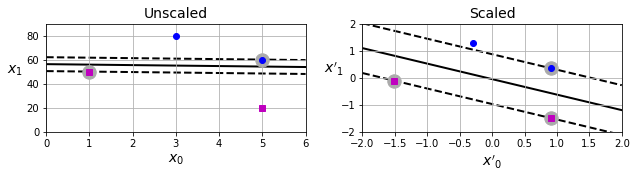

In [6]:
# extra code – this cell generates and saves Figure 5–2

from sklearn.preprocessing import StandardScaler

Xs = np.array([[1, 50], [5, 20], [3, 80], [5, 60]]).astype(np.float64)
ys = np.array([0, 0, 1, 1])
svm_clf = SVC(kernel="linear", C=100).fit(Xs, ys)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(Xs)
svm_clf_scaled = SVC(kernel="linear", C=100).fit(X_scaled, ys)

plt.figure(figsize=(9, 2.7))
plt.subplot(121)
plt.plot(Xs[:, 0][ys==1], Xs[:, 1][ys==1], "bo")
plt.plot(Xs[:, 0][ys==0], Xs[:, 1][ys==0], "ms")
plot_svc_decision_boundary(svm_clf, 0, 6)
plt.xlabel("$x_0$")
plt.ylabel("$x_1$    ", rotation=0)
plt.title("Unscaled")
plt.axis([0, 6, 0, 90])
plt.grid()

plt.subplot(122)
plt.plot(X_scaled[:, 0][ys==1], X_scaled[:, 1][ys==1], "bo")
plt.plot(X_scaled[:, 0][ys==0], X_scaled[:, 1][ys==0], "ms")
plot_svc_decision_boundary(svm_clf_scaled, -2, 2)
plt.xlabel("$x'_0$")
plt.ylabel("$x'_1$  ", rotation=0)
plt.title("Scaled")
plt.axis([-2, 2, -2, 2])
plt.grid()

save_fig("sensitivity_to_feature_scales_plot")
plt.show()

--- 

**WARNING**

SVMs are sensitive to the feature scales, as you can see in Figure above. In the left plot, the vertical scale is much larger than the horizontal scale, so the widest possible street is close to horizontal. After feature scaling (e.g., using Scikit-Learn’s `StandardScaler`), the decision boundary in the right plot looks much better.

---

## Soft Margin Classification

If we strictly impose that all instances must be off the street and on the correct side, this is called hard margin classification. There are two main issues with _hard margin classification_. First, it only works if the data is linearly separable. Second, it is sensitive to outliers. Figure below shows the iris dataset with just one additional outlier: on the left, it is impossible to find a hard margin; on the right, the decision boundary ends up very different from the one we saw in the previous figure without the outlier, and the model will probably not generalize as well.




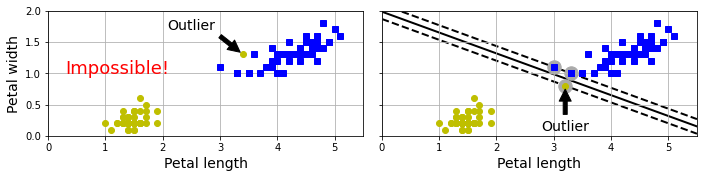

In [7]:
# Hard margin sensitivity to outliers

# extra code – this cell generates and saves Figure 5–3

X_outliers = np.array([[3.4, 1.3], [3.2, 0.8]])
y_outliers = np.array([0, 0])
Xo1 = np.concatenate([X, X_outliers[:1]], axis=0)
yo1 = np.concatenate([y, y_outliers[:1]], axis=0)
Xo2 = np.concatenate([X, X_outliers[1:]], axis=0)
yo2 = np.concatenate([y, y_outliers[1:]], axis=0)

svm_clf2 = SVC(kernel="linear", C=10**9)
svm_clf2.fit(Xo2, yo2)

fig, axes = plt.subplots(ncols=2, figsize=(10, 2.7), sharey=True)

plt.sca(axes[0])
plt.plot(Xo1[:, 0][yo1==1], Xo1[:, 1][yo1==1], "bs")
plt.plot(Xo1[:, 0][yo1==0], Xo1[:, 1][yo1==0], "yo")
plt.text(0.3, 1.0, "Impossible!", color="red", fontsize=18)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.annotate(
    "Outlier",
    xy=(X_outliers[0][0], X_outliers[0][1]),
    xytext=(2.5, 1.7),
    ha="center",
    arrowprops=dict(facecolor='black', shrink=0.1),
)
plt.axis([0, 5.5, 0, 2])
plt.grid()

plt.sca(axes[1])
plt.plot(Xo2[:, 0][yo2==1], Xo2[:, 1][yo2==1], "bs")
plt.plot(Xo2[:, 0][yo2==0], Xo2[:, 1][yo2==0], "yo")
plot_svc_decision_boundary(svm_clf2, 0, 5.5)
plt.xlabel("Petal length")
plt.annotate(
    "Outlier",
    xy=(X_outliers[1][0], X_outliers[1][1]),
    xytext=(3.2, 0.08),
    ha="center",
    arrowprops=dict(facecolor='black', shrink=0.1),
)
plt.axis([0, 5.5, 0, 2])
plt.grid()

save_fig("sensitivity_to_outliers_plot")
plt.show()

Note: the default value for the `dual` hyperparameter of the `LinearSVC` and `LinearSVR` estimators will change from `True` to `"auto"` in Scikit-Learn 1.4, so I set `dual=True` throughout this notebook to ensure the output of this notebook remains unchanged.

The following Scikit-Learn code loads the iris dataset and trains a linear SVM classifier to detect _Iris virginica_ flowers. The pipeline first scales the features, then uses a `LinearSVC` with $C=1$:

In [8]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris = load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = (iris.target == 2)  # Iris virginica

svm_clf = make_pipeline(StandardScaler(),
                        LinearSVC(C=1, dual=True, random_state=42))
svm_clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(C=1, random_state=42))])

The resulting model is represented on the left in the Figure below. Then, as usual, you can use the model to make predictions:

In [9]:
X_new = [[5.5, 1.7], [5.0, 1.5]]
svm_clf.predict(X_new)

array([ True, False])

The first plant is classified as an _Iris virginica_, while the second is not. Let’s look at the scores that the SVM used to make these predictions. These measure the signed distance between each instance and the decision boundary:

In [10]:
svm_clf.decision_function(X_new)

array([ 0.66163411, -0.22036063])

Optional: Unlike `LogisticRegression`, `LinearSVC` doesn’t have a `predict_proba()` method to estimate the class probabilities. That said, if you use the `SVC` class (discussed shortly) instead of `LinearSVC`, and if you set its probability hyperparameter to `True`, then the model will fit an extra model at the end of training to map the SVM decision function scores to estimated probabilities. Under the hood, this requires using 5-fold cross-validation to generate out-of-sample predictions for every instance in the training set, then training a `LogisticRegression` model, so it will slow down training considerably. After that, the `predict_proba()` and `predict_log_proba()` methods will be available.


To avoid the issues in hard-margin SVM, we need to use a more flexible model. The objective is to find a good balance between keeping the street as large as possible and limiting the margin violations (i.e., instances that end up in the middle of the street or even on the wrong side). This is called _soft margin classification_.

When creating an SVM model using Scikit-Learn, you can specify several hyperparameters, including the regularization hyperparameter $C$. If you set it to a low value, then you end up with the model on the left of Figure above. With a high value, you get the model on the right. As you can see, reducing $C$ makes the street larger, but it also leads to more margin violations. In other words, reducing $C$ results in more instances supporting the street, so there’s less risk of overfitting. But if you reduce it too much, then the model ends up underfitting, as seems to be the case here: the model with C=100 looks like it will generalize better than the one with $C=1$.

---
**Tip**:

If your SVM model is overfitting, you can try regularizing it by reducing C.

---



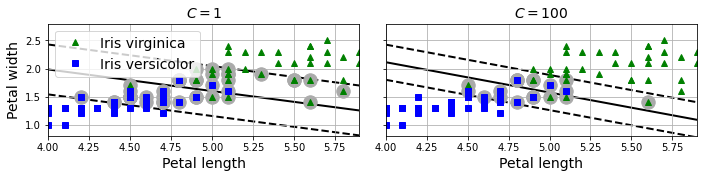

In [11]:
# extra code – this cell generates and saves Figure 5–4

scaler = StandardScaler()
svm_clf1 = LinearSVC(C=1, max_iter=10_000, dual=True, random_state=42)
svm_clf2 = LinearSVC(C=100, max_iter=10_000, dual=True, random_state=42)

scaled_svm_clf1 = make_pipeline(scaler, svm_clf1)
scaled_svm_clf2 = make_pipeline(scaler, svm_clf2)

scaled_svm_clf1.fit(X, y)
scaled_svm_clf2.fit(X, y)

# Convert to unscaled parameters
b1 = svm_clf1.decision_function([-scaler.mean_ / scaler.scale_])
b2 = svm_clf2.decision_function([-scaler.mean_ / scaler.scale_])
w1 = svm_clf1.coef_[0] / scaler.scale_
w2 = svm_clf2.coef_[0] / scaler.scale_
svm_clf1.intercept_ = np.array([b1])
svm_clf2.intercept_ = np.array([b2])
svm_clf1.coef_ = np.array([w1])
svm_clf2.coef_ = np.array([w2])

# Find support vectors (LinearSVC does not do this automatically)
t = y * 2 - 1
support_vectors_idx1 = (t * (X.dot(w1) + b1) < 1).ravel()
support_vectors_idx2 = (t * (X.dot(w2) + b2) < 1).ravel()
svm_clf1.support_vectors_ = X[support_vectors_idx1]
svm_clf2.support_vectors_ = X[support_vectors_idx2]

fig, axes = plt.subplots(ncols=2, figsize=(10, 2.7), sharey=True)

plt.sca(axes[0])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^", label="Iris virginica")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", label="Iris versicolor")
plot_svc_decision_boundary(svm_clf1, 4, 5.9)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="upper left")
plt.title(f"$C = {svm_clf1.C}$")
plt.axis([4, 5.9, 0.8, 2.8])
plt.grid()

plt.sca(axes[1])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plot_svc_decision_boundary(svm_clf2, 4, 5.99)
plt.xlabel("Petal length")
plt.title(f"$C = {svm_clf2.C}$")
plt.axis([4, 5.9, 0.8, 2.8])
plt.grid()

save_fig("regularization_plot")
plt.show()

# Nonlinear SVM Classification

Although linear SVM classifiers are efficient and often work surprisingly well, many datasets are not even close to being linearly separable. One approach to handling nonlinear datasets is to add more features, such as polynomial features (as we did in Chapter 4); in some cases this can result in a linearly separable dataset. Consider the lefthand plot in Figure below: it represents a simple dataset with just one feature, $x_1$. This dataset is not linearly separable, as you can see. But if you add a second feature $x_2 = (x_1)^2$, the resulting 2D dataset is perfectly linearly separable.



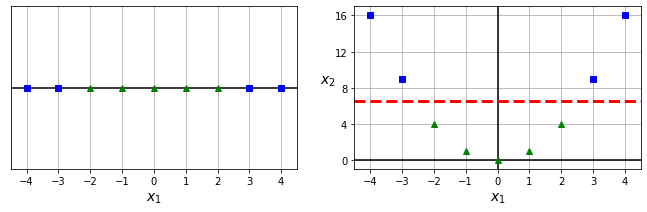

In [12]:
# extra code – this cell generates and saves Figure 5–5

X1D = np.linspace(-4, 4, 9).reshape(-1, 1)
X2D = np.c_[X1D, X1D**2]
y = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(10, 3))

plt.subplot(121)
plt.grid(True)
plt.axhline(y=0, color='k')
plt.plot(X1D[:, 0][y==0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][y==1], np.zeros(5), "g^")
plt.gca().get_yaxis().set_ticks([])
plt.xlabel("$x_1$")
plt.axis([-4.5, 4.5, -0.2, 0.2])

plt.subplot(122)
plt.grid(True)
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(X2D[:, 0][y==0], X2D[:, 1][y==0], "bs")
plt.plot(X2D[:, 0][y==1], X2D[:, 1][y==1], "g^")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$  ", rotation=0)
plt.gca().get_yaxis().set_ticks([0, 4, 8, 12, 16])
plt.plot([-4.5, 4.5], [6.5, 6.5], "r--", linewidth=3)
plt.axis([-4.5, 4.5, -1, 17])

plt.subplots_adjust(right=1)

save_fig("higher_dimensions_plot", tight_layout=False)
plt.show()

To implement this idea using Scikit-Learn, you can create a pipeline containing a `PolynomialFeatures` transformer (discussed in “`Polynomial Regression`”), followed by a `StandardScaler` and a `LinearSVC` classifier. Let’s test this on the moons dataset, a toy dataset for binary classification in which the data points are shaped as two interleaving crescent moons (see Figure below). You can generate this dataset using the `make_moons()` function:

In [13]:
from sklearn.datasets import make_moons
from sklearn.preprocessing import PolynomialFeatures

X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

polynomial_svm_clf = make_pipeline(
    PolynomialFeatures(degree=3),
    StandardScaler(),
    LinearSVC(C=10, max_iter=10_000, dual=True, random_state=42)
)
polynomial_svm_clf.fit(X, y)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('standardscaler', StandardScaler()),
                ('linearsvc',
                 LinearSVC(C=10, max_iter=10000, random_state=42))])

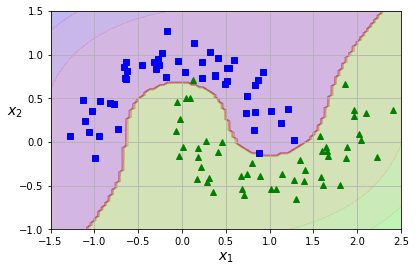

In [14]:
# extra code – this cell generates and saves Figure 5–6

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$", rotation=0)

def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

save_fig("moons_polynomial_svc_plot")
plt.show()

## Polynomial Kernel

Adding polynomial features is simple to implement and can work great with all sorts of machine learning algorithms (not just SVMs). That said, at a low polynomial degree this method cannot deal with very complex datasets, and with a high polynomial degree it creates a huge number of features, making the model too slow.

Fortunately, when using SVMs you can apply an almost miraculous mathematical technique called the **kernel trick** (which is explained later in this chapter). The kernel trick makes it possible to get the same result as if you had added many polynomial features, even with a very high degree, without actually having to add them. This means there’s no combinatorial explosion of the number of features. This trick is implemented by the SVC class. Let’s test it on the moons dataset:

In [15]:
from sklearn.svm import SVC

poly_kernel_svm_clf = make_pipeline(StandardScaler(),
                                    SVC(kernel="poly", degree=3, coef0=1, C=5))
poly_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=5, coef0=1, kernel='poly'))])

This code trains an SVM classifier using a third-degree polynomial kernel, represented on the left in Figure below. On the right is another SVM classifier using a 10th-degree polynomial kernel. Obviously, if your model is overfitting, you might want to reduce the polynomial degree. Conversely, if it is underfitting, you can try increasing it. The hyperparameter `coef0` controls how much the model is influenced by high-degree terms versus low-degree terms.

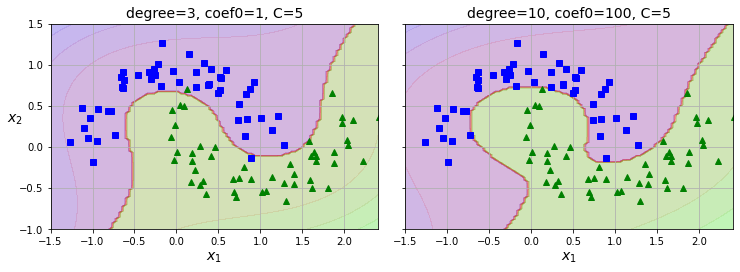

In [16]:
# extra code – this cell generates and saves Figure 5–7

poly100_kernel_svm_clf = make_pipeline(
    StandardScaler(),
    SVC(kernel="poly", degree=10, coef0=100, C=5)
)
poly100_kernel_svm_clf.fit(X, y)

fig, axes = plt.subplots(ncols=2, figsize=(10.5, 4), sharey=True)

plt.sca(axes[0])
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title("degree=3, coef0=1, C=5")

plt.sca(axes[1])
plot_predictions(poly100_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title("degree=10, coef0=100, C=5")
plt.ylabel("")

save_fig("moons_kernelized_polynomial_svc_plot")
plt.show()

---
**TIP**

Although hyperparameters will generally be tuned automatically (e.g., using randomized search), it’s good to have a sense of what each hyperparameter actually does and how it may interact with other hyperparameters: this way, you can narrow the search to a much smaller space.

---


## Similarity Features

Another technique to tackle nonlinear problems is to add features computed using a similarity function, which measures how much each instance resembles a particular landmark, as we did in Chapter 2 when we added the geographic similarity features. For example, let’s take the 1D dataset from earlier and add two landmarks to it at $x_1 = –2$ and $x_1 = 1$ (see the left plot in Figure below). Next, we’ll define the similarity function to be the Gaussian RBF with $\gamma = 0.3$. This is a bell-shaped function varying from 0 (very far away from the landmark) to 1 (at the landmark).

Now we are ready to compute the new features. For example, let’s look at the instance $x_1 = –1$: it is located at a distance of 1 from the first landmark and 2 from the second landmark. Therefore, its new features are $x_2 = \mathrm{exp}(–0.3 × 12) ≈ 0.74$ and $x_3 = \mathrm{exp}(–0.3 × 22) ≈ 0.30$. The plot on the right in Figure below shows the transformed dataset (dropping the original features). As you can see, it is now linearly separable.

You may wonder how to select the landmarks. The simplest approach is to create a landmark at the location of each and every instance in the dataset. Doing that creates many dimensions and thus increases the chances that the transformed training set will be linearly separable. The downside is that a training set with $m$ instances and $n$ features gets transformed into a training set with $m$ instances and $m$ features (assuming you drop the original features). If your training set is very large, you end up with an equally large number of features.



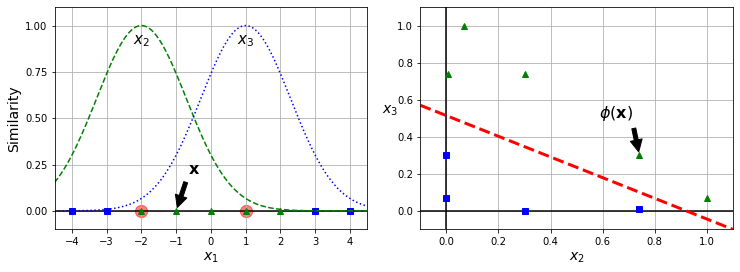

In [17]:
# extra code – this cell generates and saves Figure 5–8

def gaussian_rbf(x, landmark, gamma):
    return np.exp(-gamma * np.linalg.norm(x - landmark, axis=1)**2)

gamma = 0.3

x1s = np.linspace(-4.5, 4.5, 200).reshape(-1, 1)
x2s = gaussian_rbf(x1s, -2, gamma)
x3s = gaussian_rbf(x1s, 1, gamma)

XK = np.c_[gaussian_rbf(X1D, -2, gamma), gaussian_rbf(X1D, 1, gamma)]
yk = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(10.5, 4))

plt.subplot(121)
plt.grid(True)
plt.axhline(y=0, color='k')
plt.scatter(x=[-2, 1], y=[0, 0], s=150, alpha=0.5, c="red")
plt.plot(X1D[:, 0][yk==0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][yk==1], np.zeros(5), "g^")
plt.plot(x1s, x2s, "g--")
plt.plot(x1s, x3s, "b:")
plt.gca().get_yaxis().set_ticks([0, 0.25, 0.5, 0.75, 1])
plt.xlabel("$x_1$")
plt.ylabel("Similarity")
plt.annotate(
    r'$\mathbf{x}$',
    xy=(X1D[3, 0], 0),
    xytext=(-0.5, 0.20),
    ha="center",
    arrowprops=dict(facecolor='black', shrink=0.1),
    fontsize=16,
)
plt.text(-2, 0.9, "$x_2$", ha="center", fontsize=15)
plt.text(1, 0.9, "$x_3$", ha="center", fontsize=15)
plt.axis([-4.5, 4.5, -0.1, 1.1])

plt.subplot(122)
plt.grid(True)
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(XK[:, 0][yk==0], XK[:, 1][yk==0], "bs")
plt.plot(XK[:, 0][yk==1], XK[:, 1][yk==1], "g^")
plt.xlabel("$x_2$")
plt.ylabel("$x_3$  ", rotation=0)
plt.annotate(
    r'$\phi\left(\mathbf{x}\right)$',
    xy=(XK[3, 0], XK[3, 1]),
    xytext=(0.65, 0.50),
    ha="center",
    arrowprops=dict(facecolor='black', shrink=0.1),
    fontsize=16,
)
plt.plot([-0.1, 1.1], [0.57, -0.1], "r--", linewidth=3)
plt.axis([-0.1, 1.1, -0.1, 1.1])
    
plt.subplots_adjust(right=1)

save_fig("kernel_method_plot")
plt.show()

## Gaussian RBF Kernel

Just like the polynomial features method, the similarity features method can be useful with any machine learning algorithm, but it may be computationally expensive to compute all the additional features (especially on large training sets). Once again the kernel trick does its SVM magic, making it possible to obtain a similar result as if you had added many similarity features, but without actually doing so. Let’s try the SVC class with the Gaussian RBF kernel:

In [18]:
rbf_kernel_svm_clf = make_pipeline(StandardScaler(),
                                   SVC(kernel="rbf", gamma=5, C=0.001))
rbf_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=0.001, gamma=5))])

This model is represented at the bottom left in Figure below. The other plots show models trained with different values of hyperparameters gamma ($\gamma$) and $C$. Increasing gamma makes the bell-shaped curve narrower (see the lefthand plots in Figure below). As a result, each instance’s range of influence is smaller: the decision boundary ends up being more irregular, wiggling around individual instances. Conversely, a small gamma value makes the bell-shaped curve wider: instances have a larger range of influence, and the decision boundary ends up smoother. So γ acts like a regularization hyperparameter: if your model is overfitting, you should reduce $\gamma$; if it is underfitting, you should increase $\gamma$ (similar to the $C$ hyperparameter).



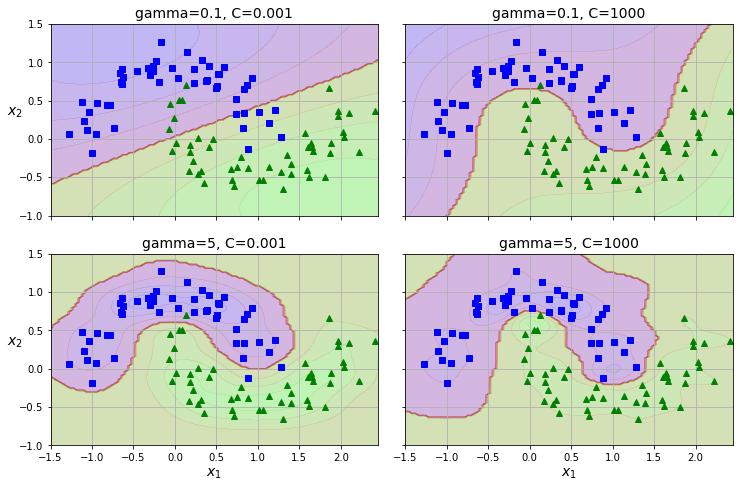

In [19]:
# extra code – this cell generates and saves Figure 5–9
# SVM classifiers using an RBF kernel


from sklearn.svm import SVC

gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = make_pipeline(
        StandardScaler(),
        SVC(kernel="rbf", gamma=gamma, C=C)
    )
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10.5, 7), sharex=True, sharey=True)

for i, svm_clf in enumerate(svm_clfs):
    plt.sca(axes[i // 2, i % 2])
    plot_predictions(svm_clf, [-1.5, 2.45, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.45, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(f"gamma={gamma}, C={C}")
    if i in (0, 1):
        plt.xlabel("")
    if i in (1, 3):
        plt.ylabel("")

save_fig("moons_rbf_svc_plot")
plt.show()

Other kernels exist but are used much more rarely. Some kernels are specialized for specific data structures. String kernels are sometimes used when classifying text documents or DNA sequences (e.g., using the string subsequence kernel or kernels based on the Levenshtein distance).

---
**Tip**

With so many kernels to choose from, how can you decide which one to use? As a rule of thumb, you should always try the linear kernel first. The `LinearSVC` class is much faster than `SVC(kernel="linear")`, especially if the training set is very large. If it is not too large, you should also try kernelized SVMs, starting with the Gaussian RBF kernel; it often works really well. Then, if you have spare time and computing power, you can experiment with a few other kernels using hyperparameter search. If there are kernels specialized for your training set’s data structure, make sure to give them a try too.

---






# SVM Regression

To use SVMs for regression instead of classification, the trick is to tweak the objective: instead of trying to fit the largest possible street between two classes while limiting margin violations, SVM regression tries to fit as many instances as possible on the street while limiting margin violations (i.e., instances off the street). The width of the street is controlled by a hyperparameter, $\epsilon$. Figure below shows two linear SVM regression models trained on some linear data, one with a small margin ($\epsilon = 0.5$ ) and the other with a larger margin ($\epsilon = 1.2$ ).

Reducing $\epsilon$ increases the number of support vectors, which regularizes the model. Moreover, if you add more training instances within the margin, it will not affect the model’s predictions; thus, the model is said to be $\epsilon$-insensitive.

You can use Scikit-Learn’s `LinearSVR` class to perform linear SVM regression. The following code produces the model represented on the left in Figure below:

In [20]:
from sklearn.svm import LinearSVR

# extra code – these 3 lines generate a simple linear dataset
np.random.seed(42)
X = 2 * np.random.rand(50, 1)
y = 4 + 3 * X[:, 0] + np.random.randn(50)

svm_reg = make_pipeline(StandardScaler(),
                        LinearSVR(epsilon=0.5, dual=True, random_state=42))
svm_reg.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvr', LinearSVR(epsilon=0.5, random_state=42))])

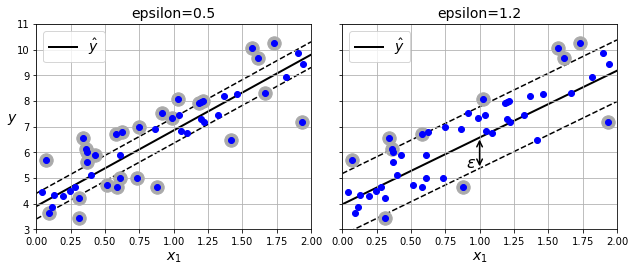

In [21]:
# extra code – this cell generates and saves Figure 5–10

def find_support_vectors(svm_reg, X, y):
    y_pred = svm_reg.predict(X)
    epsilon = svm_reg[-1].epsilon
    off_margin = np.abs(y - y_pred) >= epsilon
    return np.argwhere(off_margin)

def plot_svm_regression(svm_reg, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    epsilon = svm_reg[-1].epsilon
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$", zorder=-2)
    plt.plot(x1s, y_pred + epsilon, "k--", zorder=-2)
    plt.plot(x1s, y_pred - epsilon, "k--", zorder=-2)
    plt.scatter(X[svm_reg._support], y[svm_reg._support], s=180,
                facecolors='#AAA', zorder=-1)
    plt.plot(X, y, "bo")
    plt.xlabel("$x_1$")
    plt.legend(loc="upper left")
    plt.axis(axes)

svm_reg2 = make_pipeline(StandardScaler(),
                         LinearSVR(epsilon=1.2, dual=True, random_state=42))
svm_reg2.fit(X, y)

svm_reg._support = find_support_vectors(svm_reg, X, y)
svm_reg2._support = find_support_vectors(svm_reg2, X, y)

eps_x1 = 1
eps_y_pred = svm_reg2.predict([[eps_x1]])

fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_reg, X, y, [0, 2, 3, 11])
plt.title(f"epsilon={svm_reg[-1].epsilon}")
plt.ylabel("$y$", rotation=0)
plt.grid()
plt.sca(axes[1])
plot_svm_regression(svm_reg2, X, y, [0, 2, 3, 11])
plt.title(f"epsilon={svm_reg2[-1].epsilon}")
plt.annotate(
        '', xy=(eps_x1, eps_y_pred), xycoords='data',
        xytext=(eps_x1, eps_y_pred - svm_reg2[-1].epsilon),
        textcoords='data', arrowprops={'arrowstyle': '<->', 'linewidth': 1.5}
    )
plt.text(0.90, 5.4, r"$\epsilon$", fontsize=16)
plt.grid()
save_fig("svm_regression_plot")
plt.show()

The following code uses Scikit-Learn’s SVR class (which supports the kernel trick) to produce the model represented on the left in Figure below:

In [22]:
from sklearn.svm import SVR

# extra code – these 3 lines generate a simple quadratic dataset
np.random.seed(42)
X = 2 * np.random.rand(50, 1) - 1
y = 0.2 + 0.1 * X[:, 0] + 0.5 * X[:, 0] ** 2 + np.random.randn(50) / 10

svm_poly_reg = make_pipeline(StandardScaler(),
                             SVR(kernel="poly", degree=2, C=0.01, epsilon=0.1))
svm_poly_reg.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(C=0.01, degree=2, kernel='poly'))])

To tackle nonlinear regression tasks, you can use a kernelized SVM model. Figure below shows SVM regression on a random quadratic training set, using a second-degree polynomial kernel. There is some regularization in the left plot (i.e., a small $C$ value), and much less in the right plot (i.e., a large $C$ value).

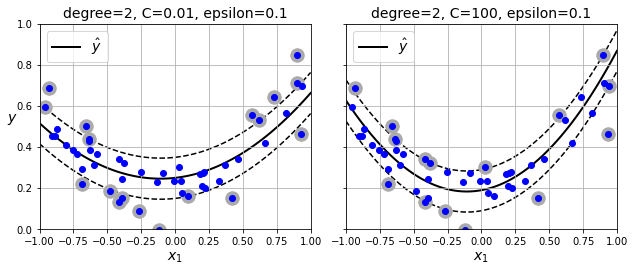

In [23]:
# extra code – this cell generates and saves Figure 5–11

# SVM regression using a second-degree polynomial kernel


svm_poly_reg2 = make_pipeline(StandardScaler(),
                             SVR(kernel="poly", degree=2, C=100))
svm_poly_reg2.fit(X, y)

svm_poly_reg._support = find_support_vectors(svm_poly_reg, X, y)
svm_poly_reg2._support = find_support_vectors(svm_poly_reg2, X, y)

fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_poly_reg, X, y, [-1, 1, 0, 1])
plt.title(f"degree={svm_poly_reg[-1].degree}, "
          f"C={svm_poly_reg[-1].C}, "
          f"epsilon={svm_poly_reg[-1].epsilon}")
plt.ylabel("$y$", rotation=0)
plt.grid()

plt.sca(axes[1])
plot_svm_regression(svm_poly_reg2, X, y, [-1, 1, 0, 1])
plt.title(f"degree={svm_poly_reg2[-1].degree}, "
          f"C={svm_poly_reg2[-1].C}, "
          f"epsilon={svm_poly_reg2[-1].epsilon}")
plt.grid()
save_fig("svm_with_polynomial_kernel_plot")
plt.show()

The `SVR` class is the regression equivalent of the `SVC` class, and the `LinearSVR` class is the regression equivalent of the `LinearSVC` class. The `LinearSVR` class scales linearly with the size of the training set (just like the `LinearSVC` class), while the `SVR` class gets much too slow when the training set grows very large (just like the `SVC` class).

The rest of this chapter explains how SVMs make predictions and how their training algorithms work, starting with linear SVM classifiers. If you are just getting started with machine learning, you can safely skip this, and come back later when you want to get a deeper understanding of SVMs.

For this part, please refer to the textbook. 

# Under the hood

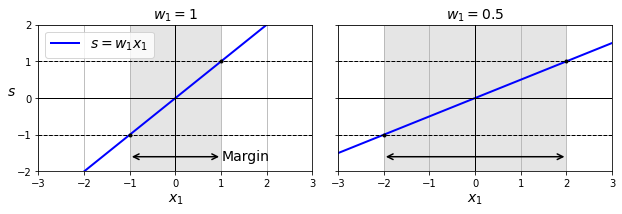

In [24]:
# extra code – this cell generates and saves Figure 5–12

import matplotlib.patches as patches

def plot_2D_decision_function(w, b, ylabel=True, x1_lim=[-3, 3]):
    x1 = np.linspace(x1_lim[0], x1_lim[1], 200)
    y = w * x1 + b
    half_margin = 1 / w

    plt.plot(x1, y, "b-", linewidth=2, label=r"$s = w_1 x_1$")
    plt.axhline(y=0, color='k', linewidth=1)
    plt.axvline(x=0, color='k', linewidth=1)
    rect = patches.Rectangle((-half_margin, -2), 2 * half_margin, 4,
                             edgecolor='none', facecolor='gray', alpha=0.2)
    plt.gca().add_patch(rect)
    plt.plot([-3, 3], [1, 1], "k--", linewidth=1)
    plt.plot([-3, 3], [-1, -1], "k--", linewidth=1)
    plt.plot(half_margin, 1, "k.")
    plt.plot(-half_margin, -1, "k.")
    plt.axis(x1_lim + [-2, 2])
    plt.xlabel("$x_1$")
    if ylabel:
        plt.ylabel("$s$", rotation=0, labelpad=5)
        plt.legend()
        plt.text(1.02, -1.6, "Margin", ha="left", va="center", color="k")

    plt.annotate(
        '', xy=(-half_margin, -1.6), xytext=(half_margin, -1.6),
        arrowprops={'ec': 'k', 'arrowstyle': '<->', 'linewidth': 1.5}
    )
    plt.title(f"$w_1 = {w}$")

fig, axes = plt.subplots(ncols=2, figsize=(9, 3.2), sharey=True)
plt.sca(axes[0])
plot_2D_decision_function(1, 0)
plt.grid()
plt.sca(axes[1])
plot_2D_decision_function(0.5, 0, ylabel=False)
plt.grid()
save_fig("small_w_large_margin_plot")
plt.show()

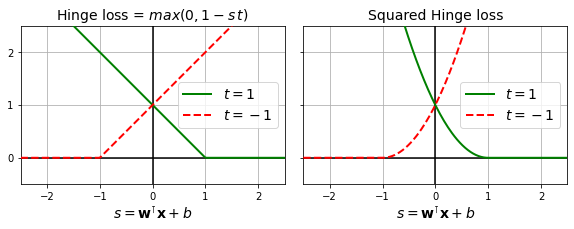

In [25]:
# extra code – this cell generates and saves Figure 5–13

s = np.linspace(-2.5, 2.5, 200)
hinge_pos = np.where(1 - s < 0, 0, 1 - s)  # max(0, 1 - s)
hinge_neg = np.where(1 + s < 0, 0, 1 + s)  # max(0, 1 + s)

titles = (r"Hinge loss = $max(0, 1 - s\,t)$", "Squared Hinge loss")

fix, axs = plt.subplots(1, 2, sharey=True, figsize=(8.2, 3))

for ax, loss_pos, loss_neg, title in zip(
        axs, (hinge_pos, hinge_pos ** 2), (hinge_neg, hinge_neg ** 2), titles):
    ax.plot(s, loss_pos, "g-", linewidth=2, zorder=10, label="$t=1$")
    ax.plot(s, loss_neg, "r--", linewidth=2, zorder=10, label="$t=-1$")
    ax.grid(True)
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    ax.set_xlabel(r"$s = \mathbf{w}^\intercal \mathbf{x} + b$")
    ax.axis([-2.5, 2.5, -0.5, 2.5])
    ax.legend(loc="center right")
    ax.set_title(title)
    ax.set_yticks(np.arange(0, 2.5, 1))
    ax.set_aspect("equal")

save_fig("hinge_plot")
plt.show()

# Extra Material

## Linear SVM classifier implementation using Batch Gradient Descent

In [26]:
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = (iris.target == 2)

In [27]:
from sklearn.base import BaseEstimator

class MyLinearSVC(BaseEstimator):
    def __init__(self, C=1, eta0=1, eta_d=10000, n_epochs=1000,
                 random_state=None):
        self.C = C
        self.eta0 = eta0
        self.n_epochs = n_epochs
        self.random_state = random_state
        self.eta_d = eta_d

    def eta(self, epoch):
        return self.eta0 / (epoch + self.eta_d)
        
    def fit(self, X, y):
        # Random initialization
        if self.random_state:
            np.random.seed(self.random_state)
        w = np.random.randn(X.shape[1], 1)  # n feature weights
        b = 0

        t = np.array(y, dtype=np.float64).reshape(-1, 1) * 2 - 1
        X_t = X * t
        self.Js = []

        # Training
        for epoch in range(self.n_epochs):
            support_vectors_idx = (X_t.dot(w) + t * b < 1).ravel()
            X_t_sv = X_t[support_vectors_idx]
            t_sv = t[support_vectors_idx]

            J = 1/2 * (w * w).sum() + self.C * ((1 - X_t_sv.dot(w)).sum() - b * t_sv.sum())
            self.Js.append(J)

            w_gradient_vector = w - self.C * X_t_sv.sum(axis=0).reshape(-1, 1)
            b_derivative = -self.C * t_sv.sum()
                
            w = w - self.eta(epoch) * w_gradient_vector
            b = b - self.eta(epoch) * b_derivative
            

        self.intercept_ = np.array([b])
        self.coef_ = np.array([w])
        support_vectors_idx = (X_t.dot(w) + t * b < 1).ravel()
        self.support_vectors_ = X[support_vectors_idx]
        return self

    def decision_function(self, X):
        return X.dot(self.coef_[0]) + self.intercept_[0]

    def predict(self, X):
        return self.decision_function(X) >= 0

In [28]:
C = 2
svm_clf = MyLinearSVC(C=C, eta0 = 10, eta_d = 1000, n_epochs=60000,
                      random_state=2)
svm_clf.fit(X, y)
svm_clf.predict(np.array([[5, 2], [4, 1]]))

array([[ True],
       [False]])

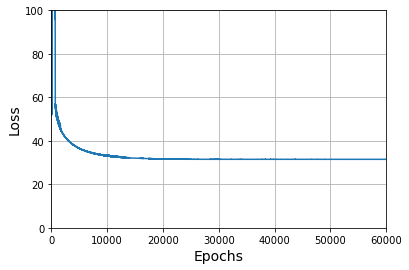

In [29]:
plt.plot(range(svm_clf.n_epochs), svm_clf.Js)
plt.axis([0, svm_clf.n_epochs, 0, 100])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.show()

In [30]:
print(svm_clf.intercept_, svm_clf.coef_)

[-15.56761653] [[[2.28120287]
  [2.71621742]]]


In [31]:
svm_clf2 = SVC(kernel="linear", C=C)
svm_clf2.fit(X, y.ravel())
print(svm_clf2.intercept_, svm_clf2.coef_)

[-15.51721253] [[2.27128546 2.71287145]]


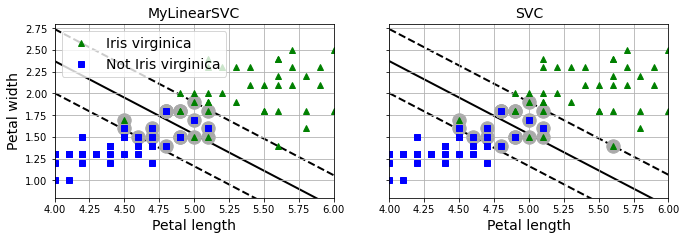

In [32]:
yr = y.ravel()
fig, axes = plt.subplots(ncols=2, figsize=(11, 3.2), sharey=True)
plt.sca(axes[0])
plt.plot(X[:, 0][yr==1], X[:, 1][yr==1], "g^", label="Iris virginica")
plt.plot(X[:, 0][yr==0], X[:, 1][yr==0], "bs", label="Not Iris virginica")
plot_svc_decision_boundary(svm_clf, 4, 6)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.title("MyLinearSVC")
plt.axis([4, 6, 0.8, 2.8])
plt.legend(loc="upper left")
plt.grid()

plt.sca(axes[1])
plt.plot(X[:, 0][yr==1], X[:, 1][yr==1], "g^")
plt.plot(X[:, 0][yr==0], X[:, 1][yr==0], "bs")
plot_svc_decision_boundary(svm_clf2, 4, 6)
plt.xlabel("Petal length")
plt.title("SVC")
plt.axis([4, 6, 0.8, 2.8])
plt.grid()

plt.show()

[-12.52988101   1.94162342   1.84544824]


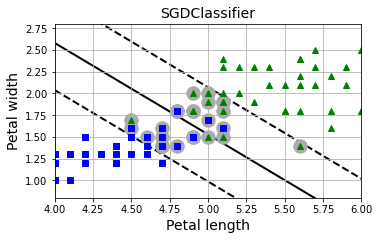

In [33]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss="hinge", alpha=0.017, max_iter=1000, tol=1e-3,
                        random_state=42)
sgd_clf.fit(X, y)

m = len(X)
t = np.array(y).reshape(-1, 1) * 2 - 1  # -1 if y == 0, or +1 if y == 1
X_b = np.c_[np.ones((m, 1)), X]  # Add bias input x0=1
X_b_t = X_b * t
sgd_theta = np.r_[sgd_clf.intercept_[0], sgd_clf.coef_[0]]
print(sgd_theta)
support_vectors_idx = (X_b_t.dot(sgd_theta) < 1).ravel()
sgd_clf.support_vectors_ = X[support_vectors_idx]
sgd_clf.C = C

plt.figure(figsize=(5.5, 3.2))
plt.plot(X[:, 0][yr==1], X[:, 1][yr==1], "g^")
plt.plot(X[:, 0][yr==0], X[:, 1][yr==0], "bs")
plot_svc_decision_boundary(sgd_clf, 4, 6)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.title("SGDClassifier")
plt.axis([4, 6, 0.8, 2.8])
plt.grid()

plt.show()